In [1]:
import sys  
sys.path.insert(1, '../../')

import matplotlib.pyplot as plt
import glob
import gc
import segyio
import numpy as np
from tqdm import tqdm
from devito import configuration, VectorTimeFunction, TensorTimeFunction
from devito import div, grad, diag, solve

from examples.seismic import AcquisitionGeometry, plot_velocity, demo_model
from examples.seismic.source import RickerSource, Receiver, TimeAxis
from devito import configuration, VectorTimeFunction, TensorTimeFunction, Eq, Operator

from scratch.util import CreateSeismicModelElastic, nn_interp_coords

configuration['ignore-unknowns'] = True

#Закоменти, чтобы выполнять на CPU
from devito import configuration
#(a) using one GPU
#(b) using multi-GPUs with MPI (requires turning the notebook into a python script)
configuration['platform'] = 'nvidiaX'
configuration['compiler'] = 'pgcc'
configuration['language'] = 'openacc'

In [2]:
# сетка
spacing = (0.2, 0.2)
shape = (int(500//spacing[0]), int(500//spacing[0]))
origin = (0, 0)
nbl = 100
so = 4

# Данные
rho_data=np.ones(shape)
vp_data=np.ones(shape)
vs_data=np.ones(shape)

# Layer 1
l1=int(2//spacing[0])
rho_data[:,0:l1] = 1.8
vp_data[:,0:l1] = 0.5
vs_data[:,0:l1] = 0.13
# Layer 2
l2=int(4.8//spacing[0])
rho_data[:,l1:l2] = 2
vp_data[:,l1:l2] = 1.7
vs_data[:,l1:l2] = 0.14
# Layer 3
l3=int(21.8//spacing[0])
rho_data[:,l2:l3] = 2
vp_data[:,l2:l3] = 1.7
vs_data[:,l2:l3] = 0.16
# Layer 4
rho_data[:,l3:] = 2.4
vp_data[:,l3:] = 1.7
vs_data[:,l3:] = 0.55

# модель
model = CreateSeismicModelElastic(origin=origin,
                        spacing=spacing,
                        shape=shape,
                        vp=vp_data,
                        vs=vs_data,
                        rho=rho_data,
                        so=so,
                        nbl=nbl,
                        bcs='damp'
                        )

#test
# vp_data[:,:] = 2.1
# vs_data[:,:] = 1.8
# rho_data[:,:] = 2.5
# model = CreateSeismicModelElastic(origin=origin,
#                         spacing=spacing,
#                         shape=shape,
#                         vp=vp_data,
#                         vs=vs_data,
#                         rho=rho_data,
#                         so=so,
#                         nbl=nbl,
#                         bcs='damp'
#                         )
# model=demo_model(preset='layers-elastic',
#            nlayers=1,
#             origin=origin,
#             spacing=spacing,
#             shape=shape,
#             so=so,
#             nbl=nbl,
#             bcs='damp'
#             )

model.damp.data[:, :100] = model.damp.data[:, 101][:, None]

pgc++-Warning- The -gpu=pinned option is deprecated; please use -gpu=mem:separate:pinnedalloc instead
Operator `initdamp` ran in 0.08 s
pgc++-Warning- The -gpu=pinned option is deprecated; please use -gpu=mem:separate:pinnedalloc instead
pgc++-Warning- The -gpu=pinned option is deprecated; please use -gpu=mem:separate:pinnedalloc instead
pgc++-Warning- The -gpu=pinned option is deprecated; please use -gpu=mem:separate:pinnedalloc instead
pgc++-Warning- The -gpu=pinned option is deprecated; please use -gpu=mem:separate:pinnedalloc instead
pgc++-Warning- The -gpu=pinned option is deprecated; please use -gpu=mem:separate:pinnedalloc instead


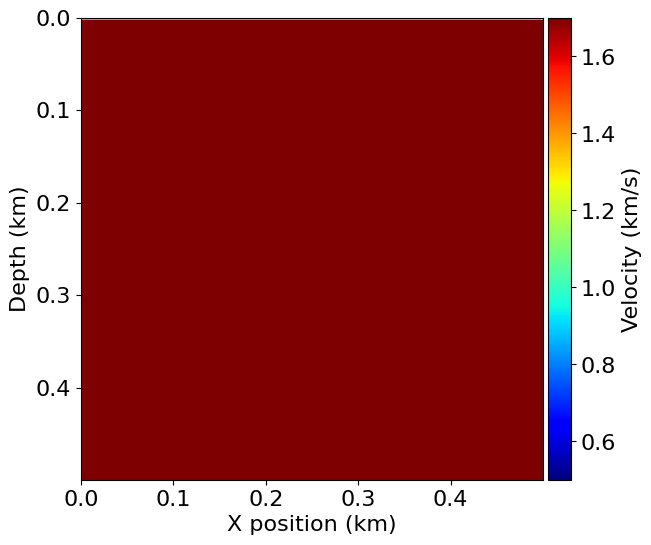

In [3]:
plot_velocity(model)

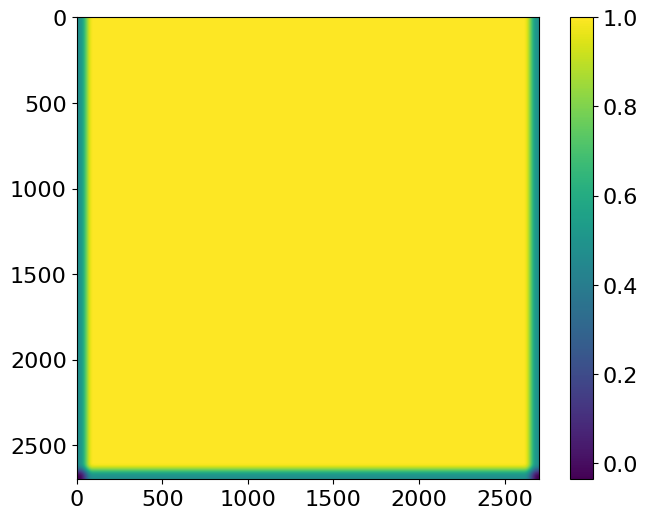

In [4]:
plt.imshow(model.damp.data.T)
plt.colorbar()

In [6]:
# геометрия
t0=0.
tn=2000.
dt = model.critical_dt/2
time_range = TimeAxis(start=t0, stop=tn, step=dt)
f0=0.02

nsrc = 1
src_coordinates = np.empty((nsrc, 2))
src_coordinates[:, 0] = 250
src_coordinates[:, 1] = 0

nrec = 72
rec_coordinates = np.empty((nrec, 2))
rec_coordinates[:,0] = np.arange(src_coordinates[0,0]+6,src_coordinates[0,0]+ 6 + nrec*2, 2)
rec_coordinates[:,1] = 0



In [ ]:
for i, src_coords in enumerate(tqdm(src_coordinates)):
    print('Source - ', i, '; Coordinate - ', src_coords)

    src = RickerSource(name='src', grid = model.grid, f0=f0, time_range=time_range, npoint=1)
    src.coordinates.data[:] = src_coords
    
    v = VectorTimeFunction(name='v', grid=model.grid,
                           space_order=so, time_order=2)
    tau = TensorTimeFunction(name='tau', grid=model.grid,
                             space_order=so, time_order=2)

    lam, mu, b = model.lam, model.mu, model.b

    eq_v = v.dt - b * div(tau)
    # Stress
    e = (grad(v.forward) + grad(v.forward).transpose(inner=False))
    eq_tau = tau.dt - lam * diag(div(v.forward)) - mu * e

    u_v = Eq(v.forward, model.damp * solve(eq_v, v.forward))
    u_t = Eq(tau.forward, model.damp * solve(eq_tau, tau.forward))

    s = model.grid.time_dim.spacing
    # Source symbol with input wavelet

    rec = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
    rec.coordinates.data[:,0] = rec_coordinates[:,0]
    rec.coordinates.data[:,1] = 0

    # rec = Receiver(name="rec", grid=model.grid, npoint=250, time_range=time_range)
    # rec.coordinates.data[:,0] = np.arange(0, model.domain_size[0],2)#rec_coordinates[:,0]
    # rec.coordinates.data[:,1] = 0
    
    rec_term = rec.interpolate(expr=v[1])
    # The source injection term
    # src_expr = src.inject(tau.forward[1, 1], expr=src * s)
    src_expr = src.inject(v.forward[1], expr=src * s)

    srcrec = src_expr + rec_term
    op = Operator([u_v] + [u_t] + srcrec, subs=model.spacing_map, name="ForwardElastic",
                  # opt=('noop', {'openmp': True}),
                 )
    summary = op.apply(dt=dt)
    ## выгрузка в sgy
    dt_r = 0.5
    rec = rec.resample(dt=dt_r)

    path = '../Results/2d_elastic'
    segyio.tools.from_array2D(path +'/2d_AM_SRC-'+str(int(src_coords[0]))+'.sgy', rec.data.T, dt=dt_r*10**3)
    with segyio.open(path+'/2d_AM_SRC-'+str(int(src_coords[0]))+'.sgy', 'r+') as f:
        for j in range(len(f.header)):
            f.header[j] = {segyio.TraceField.SourceGroupScalar : -100,
                            segyio.TraceField.SourceX : int(src_coords[0]*100),
                            segyio.TraceField.GroupX : np.array(rec.coordinates.data[j,0], dtype = int)
                            }

  0%|          | 0/1 [00:00<?, ?it/s]

Source -  0 ; Coordinate -  [250.   0.]


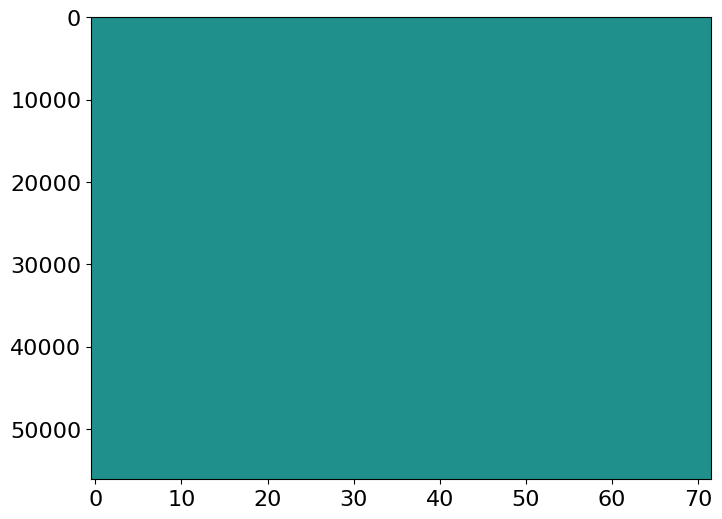

In [7]:
plt.imshow(rec.data[:], aspect='auto', vmin=-.5*1e-3, vmax=.5*1e-3)

In [8]:
slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]
scale = .5*1e-3
plt.ioff()
for i in range(0,3001, 100):
    if i==0:
        continue
    summary = op.apply(dt=dt, time_m=i-100,time_M=i)
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.imshow(np.transpose(v[1].data[1][slices]), vmin=-scale, vmax=scale, cmap="RdGy")
    ax.imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, cmap="jet", alpha=.5)
    ax.set_aspect('auto')
    ax.set_title(r"$v_{z}$", fontsize=20)
    ax.set_xlabel('X (m)', fontsize=20)
    ax.set_ylabel('Depth (m)', fontsize=20)
    plt.savefig('Results/2d_elastic/snap-'+str(i)+'.png')
    plt.close(fig)

Operator `ForwardElastic` ran in 0.32 s
Operator `ForwardElastic` ran in 0.31 s
Operator `ForwardElastic` ran in 0.31 s
Operator `ForwardElastic` ran in 0.31 s
Operator `ForwardElastic` ran in 0.31 s
Operator `ForwardElastic` ran in 0.32 s
Operator `ForwardElastic` ran in 0.33 s
Operator `ForwardElastic` ran in 0.31 s
Operator `ForwardElastic` ran in 0.33 s
Operator `ForwardElastic` ran in 0.33 s
Operator `ForwardElastic` ran in 0.33 s
Operator `ForwardElastic` ran in 0.31 s
Operator `ForwardElastic` ran in 0.30 s
Operator `ForwardElastic` ran in 0.31 s
Operator `ForwardElastic` ran in 0.31 s
Operator `ForwardElastic` ran in 0.31 s
Operator `ForwardElastic` ran in 0.31 s
Operator `ForwardElastic` ran in 0.31 s
Operator `ForwardElastic` ran in 0.31 s
Operator `ForwardElastic` ran in 0.31 s
Operator `ForwardElastic` ran in 0.36 s
Operator `ForwardElastic` ran in 0.36 s
Operator `ForwardElastic` ran in 0.30 s
Operator `ForwardElastic` ran in 0.34 s
Operator `ForwardElastic` ran in 0.32 s


KeyboardInterrupt: 

In [10]:
plot_velocity(model, source = src.coordinates.data[:], receiver=rec.coordinates.data)

NameError: name 'src' is not defined

Text(0, 0.5, 'Depth (m)')

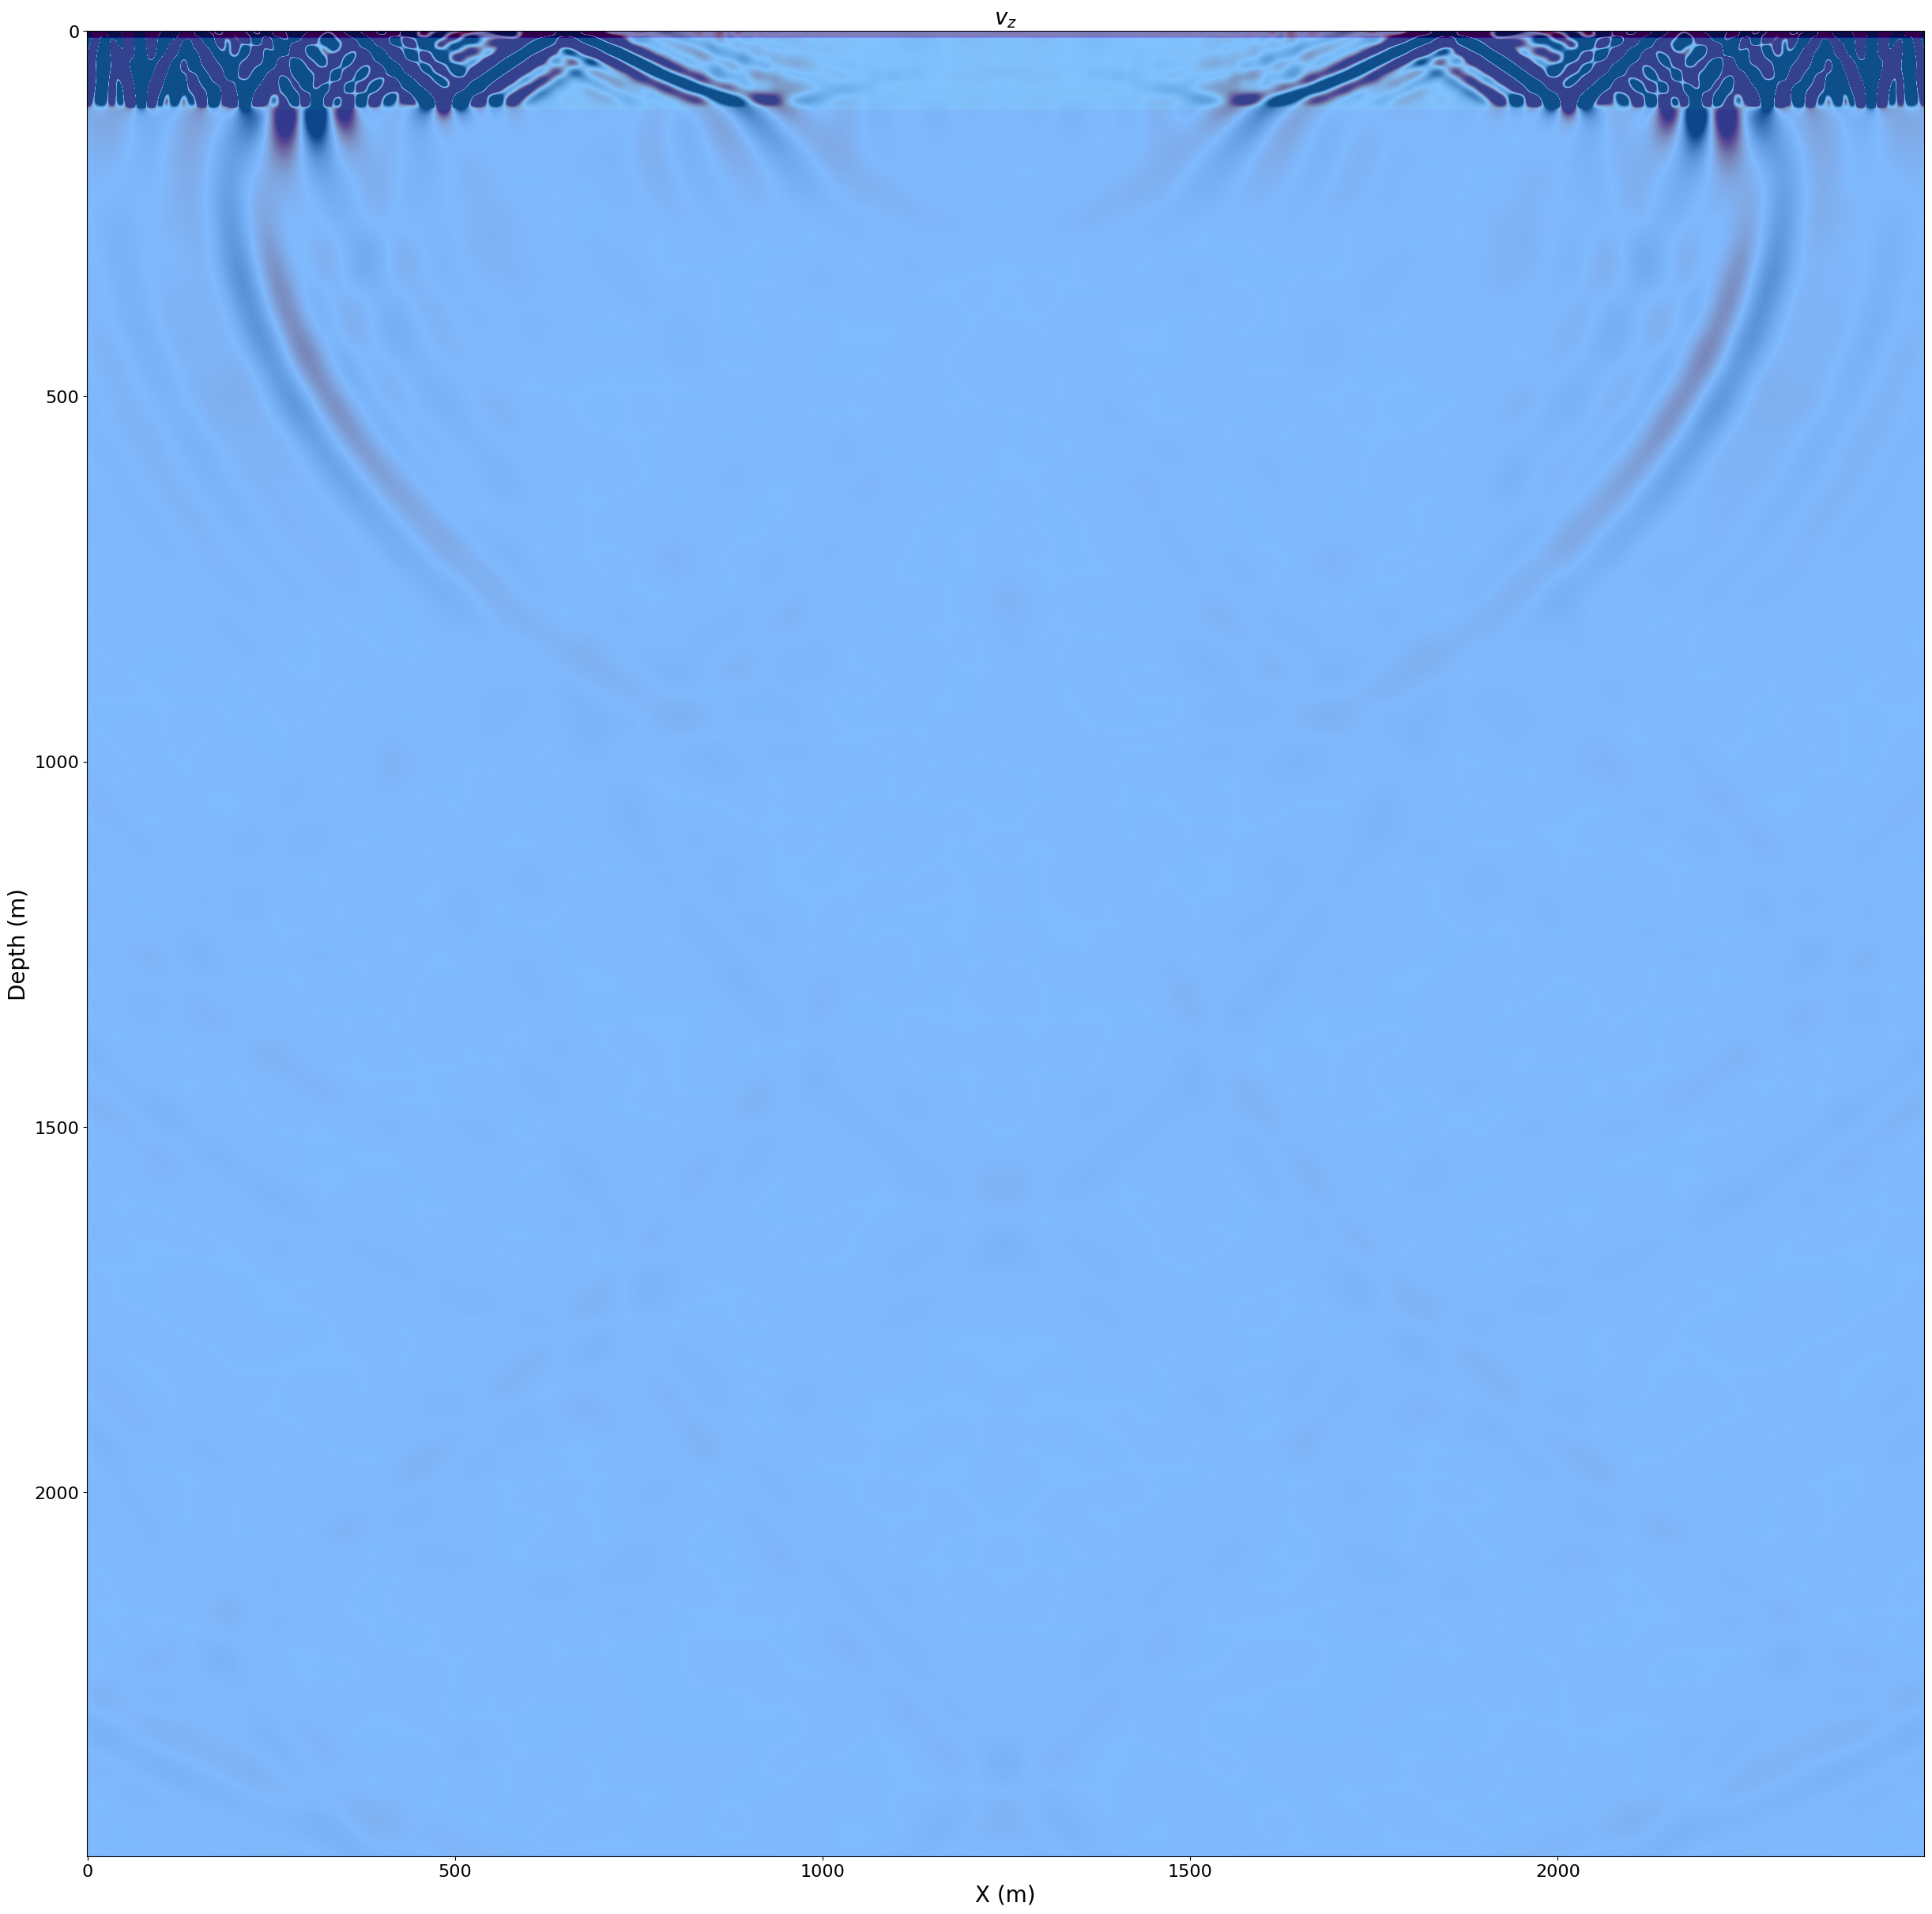

In [13]:
slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]
scale = 1e-4
fig, ax = plt.subplots(figsize=(30, 30))
ax.imshow(np.transpose(v[1].data[0][slices]), vmin=-scale, vmax=scale, cmap="RdGy")
ax.imshow(np.transpose(model.lam.data[slices]), vmin=2.5, vmax=15.0, cmap="jet", alpha=.5)
ax.set_aspect('auto')
ax.set_title(r"$v_{z}$", fontsize=20)
ax.set_xlabel('X (m)', fontsize=20)
ax.set_ylabel('Depth (m)', fontsize=20)